# Домашнее задание: Multi-Branch MLP для Wine Quality

**Цель**: Реализовать multi-branch модель и добиться F1 score ≥ 40%

**Задачи**:
1. Реализовать три типа блоков: Bottleneck, Inverted Bottleneck, Regular
2. Создать Multi-Branch архитектуру
3. Использовать weighted loss для борьбы с дисбалансом классов
4. Подобрать оптимальные гиперпараметры (глубина, ширина, lr, оптимизатор)

In [47]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score

sns.set_style('whitegrid')
set_seed(42)

## 1. Загрузка и анализ данных

Загрузим Wine Quality датасет и проанализируем распределение классов.

In [48]:
# Загружаем данные
dm = WineQualityDataModule(batch_size=128)
dm.setup()

print(f'Train samples: {len(dm.train_dataset)}')
print(f'Val samples: {len(dm.val_dataset)}')
print(f'Input dim: {dm.input_dim}')
print(f'Num classes: {dm.n_classes}')

Train samples: 1279
Val samples: 320
Input dim: 11
Num classes: 6


### 1.1. Анализ дисбаланса классов

Проанализируйте распределение классов и вычислите веса для weighted loss.

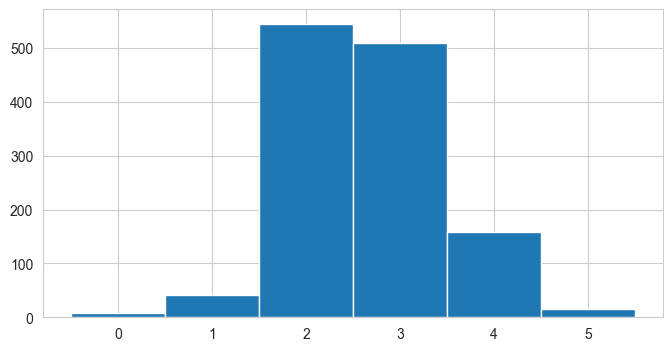

Class weights: [26.64583333  5.07539683  0.3911315   0.41797386  1.34067086 14.21111111]


In [49]:
# Получаем метки классов из train_dataset
# dm.train_dataset[i] возвращает (X, y)
train_labels = []
for i in range(len(dm.train_dataset)):
    y = dm.train_dataset[i][1].item()
    train_labels.append(int(y))
train_labels = np.array(train_labels)

# Постройте гистограмму распределения классов
# plt.hist(...)
plt.figure(figsize=(8, 4))
bins = np.arange(dm.n_classes + 1) - 0.5
plt.hist(train_labels, bins=bins)
plt.xticks(range(dm.n_classes))
plt.show()

# Вычислите веса классов используя compute_class_weight
# Веса должны быть обратно пропорциональны частоте класса (однако это может не работать, поэтому можете подобрать сами)
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)

print(f'Class weights: {class_weights}')

## 2. Реализация блоков

Реализуйте три типа блоков:
- **Bottleneck**: dim → dim//4 → dim (сужение)
- **Inverted Bottleneck**: dim → dim*4 → dim (расширение)
- **Regular**: dim → hidden_dim → dim (обычный)

In [50]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """Базовый класс для MLP блока"""
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__()
        self.dim = dim
        self.activation = {'relu': nn.ReLU(), 'gelu': nn.GELU(), 'swish': nn.SiLU()}.get(activation, nn.GELU())
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    
    @abstractmethod
    def forward(self, x):
        pass

class BottleneckBlock(BaseMLPBlock):
    """
    Bottleneck блок: dim → dim//4 → dim
    
    Сужает размерность в 4 раза, затем восстанавливает.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Bottleneck dimension (сужение в 4 раза)
        self.bottleneck_dim = max(dim // 4, 1)
        
        # Линейные слои: dim → bottleneck_dim → dim
        self.fc1 = nn.Linear(self.dim, self.bottleneck_dim)
        self.fc2 = nn.Linear(self.bottleneck_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

class InvertedBottleneckBlock(BaseMLPBlock):
    """
    Inverted Bottleneck блок: dim → dim*4 → dim
    
    Расширяет размерность в 4 раза, затем сжимает обратно.
    Использует residual connection для стабильного обучения.
    """
    def __init__(self, dim, expansion_factor=4, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Expanded dimension (расширение в 4 раза)
        self.expanded_dim = dim * expansion_factor
        
        # Линейные слои: dim → expanded_dim → dim
        self.fc1 = nn.Linear(self.dim, self.expanded_dim)
        self.fc2 = nn.Linear(self.expanded_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Inverted bottleneck pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

class RegularBlock(BaseMLPBlock):
    """
    Regular блок: dim → hidden_dim → dim
    
    Обычный двухслойный MLP с residual connection.
    hidden_dim по умолчанию равен dim * 2.
    """
    def __init__(self, dim, hidden_dim=None, activation='gelu', dropout=0.0):
        super().__init__(dim, activation, dropout)
        
        # Hidden dimension (по умолчанию в 2 раза больше)
        self.hidden_dim = hidden_dim if hidden_dim else dim * 2
        
        # Линейные слои: dim → hidden_dim → dim
        self.fc1 = nn.Linear(self.dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.dim)
    
    def forward(self, x):
        identity = x
        
        # Regular pathway
        out = self.fc1(x)
        out = self.activation(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.fc2(out)
        
        # Residual connection
        return out + identity

# Тестируем блоки
print('✓ Блоки успешно определены!')
print()

# Проверим размерности
test_x = torch.randn(4, 64)
print('Тестирование блоков с размерностью 64:')
print(f'  Input shape: {test_x.shape}')

bottleneck = BottleneckBlock(64)
print(f'  BottleneckBlock output: {bottleneck(test_x).shape}')

inverted = InvertedBottleneckBlock(64)
print(f'  InvertedBottleneckBlock output: {inverted(test_x).shape}')

regular = RegularBlock(64)
print(f'  RegularBlock output: {regular(test_x).shape}')

# Подсчитаем параметры
print()
print('Количество параметров:')
print(f'  BottleneckBlock: {sum(p.numel() for p in bottleneck.parameters()):,}')
print(f'  InvertedBottleneckBlock: {sum(p.numel() for p in inverted.parameters()):,}')
print(f'  RegularBlock: {sum(p.numel() for p in regular.parameters()):,}')

✓ Блоки успешно определены!

Тестирование блоков с размерностью 64:
  Input shape: torch.Size([4, 64])
  BottleneckBlock output: torch.Size([4, 64])
  InvertedBottleneckBlock output: torch.Size([4, 64])
  RegularBlock output: torch.Size([4, 64])

Количество параметров:
  BottleneckBlock: 2,128
  InvertedBottleneckBlock: 33,088
  RegularBlock: 16,576


## 3. Multi-Branch модель

Реализуйте модель с тремя параллельными ветками.

**Архитектура**:
```
         Input
           |
      projection
           |
      ┌────┼────┐
      │    │    │
  Bottleneck  Inverted  Regular
   Branch      Branch    Branch
      │    │    │
      └────┼────┘
           |
      Concatenate/Sum
           |
      projection
           |
        Output
```

In [51]:
class MultiBranchMLP(nn.Module):
    """
    Multi-Branch MLP с тремя параллельными ветками.

    Args:
        input_dim: размерность входа
        hidden_dim: размерность скрытых слоев
        output_dim: размерность выхода (число классов)
        num_blocks: количество блоков в каждой ветке
        dropout: вероятность dropout
        combine_mode: способ объединения веток ('concat' или 'sum')
    """
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        num_blocks=4,
        dropout=0.1,
        combine_mode='concat'
    ):
        super().__init__()
        self.output_dim = output_dim
        self.combine_mode = combine_mode
  
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.act = nn.GELU() 

        self.bottleneck_branch = nn.ModuleList([BottleneckBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)])
        self.inverted_branch = nn.ModuleList([InvertedBottleneckBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)])
        self.regular_branch = nn.ModuleList([RegularBlock(hidden_dim, dropout=dropout) for _ in range(num_blocks)])

        if combine_mode == 'concat':
            out_in_dim = hidden_dim * 3
        if combine_mode == 'sum':
            out_in_dim = hidden_dim

        self.output_proj = nn.Linear(out_in_dim, output_dim)

    def forward(self, x):
        x = self.act(self.input_proj(x))

        b1 = x
        for block in self.bottleneck_branch:
            b1 = block(b1)

        b2 = x
        for block in self.inverted_branch:
            b2 = block(b2)

        b3 = x
        for block in self.regular_branch:
            b3 = block(b3)

        if self.combine_mode == 'concat':
            combined = torch.cat([b1, b2, b3], dim=-1)
        if self.combine_mode == 'sum':
            combined = b1 + b2 + b3

        return self.output_proj(combined)

print('Multi-Branch модель определена!')

Multi-Branch модель определена!


## 4. Код обучение

In [52]:
def train_model(
    model,
    dm,
    class_weights=None,
    max_epochs=50,
    lr=1e-3,
    optimizer_type='adam'
):
    """
    Обучает модель с weighted loss.
    
    Args:
        model: модель для обучения
        dm: DataModule
        class_weights: веса классов для weighted loss (numpy array или None)
        max_epochs: количество эпох
        lr: learning rate
        optimizer_type: тип оптимизатора ('adam', 'adamw', 'sgd')
    
    Returns:
        dict с метриками
    """

    # Создайте loss function
    # Если class_weights не None, используйте nn.CrossEntropyLoss(weight=torch.FloatTensor(class_weights))
    # Иначе используйте обычный nn.CrossEntropyLoss()
    if class_weights is not None:
        weight = torch.tensor(class_weights, dtype=torch.float32)
        loss_fn = nn.CrossEntropyLoss(weight=weight)
    else:
        loss_fn = nn.CrossEntropyLoss()

    # Попытка сделать EarlyStopping
    callbacks = [EarlyStopping(monitor='val_f1_macro', mode='max', patience=8)]

    lightning_model = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type=optimizer_type,
        learning_rate=lr,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=max_epochs,
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
        enable_model_summary=False,
        callbacks=callbacks
    )
    trainer.fit(lightning_model, dm)
    
    metrics = trainer.callback_metrics
    return {
        'val_acc': metrics.get('val_accuracy', 0).item(),
        'val_f1': metrics.get('val_f1_macro', 0).item()
    }

## 5. Итоговая модель

Обучите модель с лучшими гиперпараметрами.

In [53]:
def evaluate_model(model, dm):
    model.eval()
    device = next(model.parameters()).device

    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in dm.val_dataloader():
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1).cpu()

            y_true.append(y.cpu())
            y_pred.append(preds)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    acc = (y_true == y_pred).mean()
    f1_per_class = f1_score(y_true, y_pred, average=None, labels=np.arange(dm.n_classes))
    f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f'\n=== Итоговые результаты ===')
    print(f"val_acc: {acc:.4f}")
    print(f"val_f1_macro: {f1_macro:.4f}")
    print("f1_per_class:", np.round(f1_per_class, 4))

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(dm.n_classes))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (val)')
    plt.show()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 0: accuracy=0.1094, f1_macro=0.0931

Epoch 0: accuracy=0.1910, f1_macro=0.1378

Epoch 1: accuracy=0.2723, f1_macro=0.1816

Epoch 2: accuracy=0.3298, f1_macro=0.2140

Epoch 3: accuracy=0.3353, f1_macro=0.2139

Epoch 4: accuracy=0.3464, f1_macro=0.2190

Epoch 5: accuracy=0.3470, f1_macro=0.2207

Epoch 6: accuracy=0.3674, f1_macro=0.2301

Epoch 7: accuracy=0.3587, f1_macro=0.2248

Epoch 8: accuracy=0.3635, f1_macro=0.2288

Epoch 9: accuracy=0.3652, f1_macro=0.2323

Epoch 10: accuracy=0.3742, f1_macro=0.2373

Epoch 11: accuracy=0.3748, f1_macro=0.2363

Epoch 12: accuracy=0.3723, f1_macro=0.2355

Epoch 13: accuracy=0.3788, f1_macro=0.2392

Epoch 14: accuracy=0.3799, f1_macro=0.2401

Epoch 15: accuracy=0.3847, f1_macro=0.2431

Epoch 16: accuracy=0.3876, f1_macro=0.2448

Epoch 17: accuracy=0.3918, f1_macro=0.2470

Epoch 18: accuracy=0.3963, f1_macro=0.2497

Epoch 19: accuracy=0.4001, f1_macro=0.2513

Epoch 20: accuracy=0.4005, f1_macro=0.2519

Epoch 21: accuracy=0.4036, f1_macro=0.2535

Epoch 22: accuracy=0.4055, f1_macro=0.2546

Epoch 23: accuracy=0.4118, f1_macro=0.2587

Epoch 24: accuracy=0.4140, f1_macro=0.2601

Epoch 25: accuracy=0.4160, f1_macro=0.2620

Epoch 26: accuracy=0.4176, f1_macro=0.2630

Epoch 27: accuracy=0.4184, f1_macro=0.2638

Epoch 28: accuracy=0.4211, f1_macro=0.2651

Epoch 29: accuracy=0.4230, f1_macro=0.2662

Epoch 30: accuracy=0.4253, f1_macro=0.2676

Epoch 31: accuracy=0.4278, f1_macro=0.2694

Epoch 32: accuracy=0.4290, f1_macro=0.2698

Epoch 33: accuracy=0.4314, f1_macro=0.2711

Epoch 34: accuracy=0.4318, f1_macro=0.2717

Epoch 35: accuracy=0.4316, f1_macro=0.2719

Epoch 36: accuracy=0.4332, f1_macro=0.2728

Epoch 37: accuracy=0.4357, f1_macro=0.2744

Epoch 38: accuracy=0.4374, f1_macro=0.2756

Epoch 39: accuracy=0.4391, f1_macro=0.2765

Epoch 40: accuracy=0.4426, f1_macro=0.2785

Epoch 41: accuracy=0.4430, f1_macro=0.2789

Epoch 42: accuracy=0.4451, f1_macro=0.2798

Epoch 43: accuracy=0.4449, f1_macro=0.2800

Epoch 44: accuracy=0.4458, f1_macro=0.2802

Epoch 45: accuracy=0.4431, f1_macro=0.2787

Epoch 46: accuracy=0.4430, f1_macro=0.2784

Epoch 47: accuracy=0.4429, f1_macro=0.2785

Epoch 48: accuracy=0.4439, f1_macro=0.2790

Epoch 49: accuracy=0.4453, f1_macro=0.2798

Epoch 50: accuracy=0.4460, f1_macro=0.2803

Epoch 51: accuracy=0.4476, f1_macro=0.2812

Epoch 52: accuracy=0.4493, f1_macro=0.2822

Epoch 53: accuracy=0.4507, f1_macro=0.2830

Epoch 54: accuracy=0.4518, f1_macro=0.2836

Epoch 55: accuracy=0.4536, f1_macro=0.2848

Epoch 56: accuracy=0.4552, f1_macro=0.2856

Epoch 57: accuracy=0.4570, f1_macro=0.2867

Epoch 58: accuracy=0.4588, f1_macro=0.2878

Epoch 59: accuracy=0.4606, f1_macro=0.2889

Epoch 60: accuracy=0.4627, f1_macro=0.2900

Epoch 61: accuracy=0.4636, f1_macro=0.2905

Epoch 62: accuracy=0.4650, f1_macro=0.2912

Epoch 63: accuracy=0.4663, f1_macro=0.2921

Epoch 64: accuracy=0.4678, f1_macro=0.2928

Epoch 65: accuracy=0.4698, f1_macro=0.2941

Epoch 66: accuracy=0.4707, f1_macro=0.2946

Epoch 67: accuracy=0.4727, f1_macro=0.2956

Epoch 68: accuracy=0.4734, f1_macro=0.2958

Epoch 69: accuracy=0.4747, f1_macro=0.2966

Epoch 70: accuracy=0.4762, f1_macro=0.2975

Epoch 71: accuracy=0.4776, f1_macro=0.2982

Epoch 72: accuracy=0.4791, f1_macro=0.2990

Epoch 73: accuracy=0.4805, f1_macro=0.2996

Epoch 74: accuracy=0.4818, f1_macro=0.3004

Epoch 75: accuracy=0.4826, f1_macro=0.3007

Epoch 76: accuracy=0.4836, f1_macro=0.3011

Epoch 77: accuracy=0.4847, f1_macro=0.3018

Epoch 78: accuracy=0.4855, f1_macro=0.3023

Epoch 79: accuracy=0.4862, f1_macro=0.3026

Epoch 80: accuracy=0.4872, f1_macro=0.3029

Epoch 81: accuracy=0.4879, f1_macro=0.3035

Epoch 82: accuracy=0.4883, f1_macro=0.3036

Epoch 83: accuracy=0.4888, f1_macro=0.3041

Epoch 84: accuracy=0.4901, f1_macro=0.3049

Epoch 85: accuracy=0.4914, f1_macro=0.3057

Epoch 86: accuracy=0.4922, f1_macro=0.3062

Epoch 87: accuracy=0.4934, f1_macro=0.3069

Epoch 88: accuracy=0.4943, f1_macro=0.3075

Epoch 89: accuracy=0.4953, f1_macro=0.3079

Epoch 90: accuracy=0.4964, f1_macro=0.3085

Epoch 91: accuracy=0.4974, f1_macro=0.3091

Epoch 92: accuracy=0.4985, f1_macro=0.3097

Epoch 93: accuracy=0.4997, f1_macro=0.3104

Epoch 94: accuracy=0.5008, f1_macro=0.3110

Epoch 95: accuracy=0.5019, f1_macro=0.3117

Epoch 96: accuracy=0.5032, f1_macro=0.3123

Epoch 97: accuracy=0.5041, f1_macro=0.3129

Epoch 98: accuracy=0.5051, f1_macro=0.3134

Epoch 99: accuracy=0.5064, f1_macro=0.3142

`Trainer.fit` stopped: `max_epochs=100` reached.



=== Итоговые результаты ===
val_acc: 0.6375
val_f1_macro: 0.4068
f1_per_class: [0.     0.2667 0.7068 0.6454 0.6    0.2222]


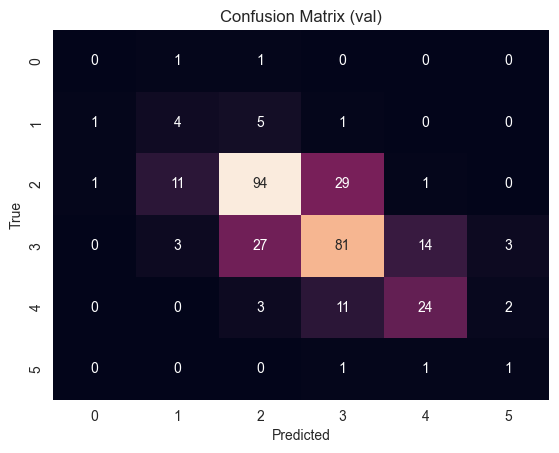

In [57]:
best_depth = 4
best_hidden_dim = 128
best_lr = 1e-3
best_optimizer = 'adamw'

final_model = MultiBranchMLP(
    input_dim=dm.input_dim,
    hidden_dim=best_hidden_dim,
    output_dim=dm.n_classes,
    num_blocks=best_depth,
    dropout=0.1,
    combine_mode='concat'
)

final_results = train_model(
    final_model,
    dm,
    class_weights=class_weights,
    max_epochs=100,
    lr=best_lr,
    optimizer_type=best_optimizer
)

evaluate_model(final_model, dm)